In [1]:
from pathlib import Path
import sys

#Fly class
from fly import MovingFly
#Simulation definition, more detail in simulation_CPG.py
from simulation_CPG import Simulation_CPG

#Flygym package
from flygym.examples.cpg_controller import CPGNetwork
from flygym.vision import save_video_with_vision_insets
from flygym import Parameters, NeuroMechFly
from flygym.examples.common import PreprogrammedSteps
from flygym import Fly, Simulation, Camera, get_data_path
from flygym.arena import FlatTerrain
from flygym.preprogrammed import all_leg_dofs

#Crop the image from the ommatidia into an hexagonal
from utils import crop_hex_to_rect

# Vision library
import torch
from torch import nn
import torch.nn.functional as F
import cv2
import numpy as np

#Filtering initialization :
import numpy as np
from collections import deque

#Plotting
from tqdm import trange
import pickle
import matplotlib.pyplot as plt
from IPython import display

In [2]:
def scenario(start_postion=0):
    pos = (0,4.5,0)
    orien_fwd = (0,0,np.pi/2)
    orien_bcd =(0,0,-np.pi/2)

    match start_postion:
        case 0 : return pos, orien_fwd #front right
        case 1: #back right
            pos = (16,4.5,0)
            return pos, orien_bcd
        case 2: #back left
            pos = (16,-4.5,0)
            return pos, orien_bcd
        case 3 :  #front left
            return (0,-5,0), orien_fwd
        case TypeError:
            print("wrong start_position, default values taken")
            return pos, orien_fwd

In [3]:
########################## Choose the desired scenario ###############################
scenario_fly1=3

In [4]:
########################## Camera and fly initialization ###############################

timestep = 1e-4

fly = Fly(
    name="1",
    init_pose="stretch",
    actuated_joints=all_leg_dofs,
    control="position",
    enable_adhesion=True,
    draw_adhesion=False,
    spawn_pos= scenario(scenario_fly1)[0],
    spawn_orientation = scenario(scenario_fly1)[1]
)

fly0 = MovingFly(

    name="0", #static
    init_pose="stretch",
    actuated_joints=all_leg_dofs,
    control="position",
    enable_adhesion=True,
    head_stabilization_model="thorax",
    neck_kp=1000,
    initial_position=(8,0,0), #position
    initial_orientation = (0,0,-np.pi/2)
)


arena = FlatTerrain()

birdeye_cam_zoom = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam_zoom",
    mode="fixed",
    pos=(15, 0, 20),
    euler=(0, 0, 0),
    fovy=45,
)

birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam",
    mode="fixed",
    pos=(15, 0, 35),
    euler=(0, 0, 0),
    fovy=45,
)

cam = Camera(
    fly=fly0,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(600, 400),
)

cam1 = Camera(fly=fly0, play_speed=0.2, draw_contacts=False, camera_follows_fly_orientation=True)

camFront = Camera(fly=fly0, camera_id="Animat/camera_front")
camRight = Camera(fly=fly0, camera_id="Animat/camera_right")
camLeft = Camera(fly=fly0, camera_id="Animat/camera_left")


sim = Simulation(
    flies=[fly0, fly],
    cameras=[cam1, cam, camFront, camRight, camLeft],
    arena=arena,
    timestep=timestep,
)

simulation_cpg = Simulation_CPG(timestep)

In [5]:
########################## Vision Model definition ###############################
#to see the training -> vision.ipynb

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Define your layers here
        self.conv1 = nn.Conv2d(2, 8, 3, groups=2)  # Convolutional layer
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3, groups=2)  # Convolutional layer
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 8, 3, groups=2)  # Convolutional layer
        self.pool3 = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.fc1 = nn.LazyLinear(16)  # Lazy linear layer
        self.fc2 = nn.Linear(16, 16)  # Linear layer
        self.fc3 = nn.Linear(16, 2)   # Linear layer for output

    def forward(self, x):
        # Define the forward pass
        x = F.tanh(self.conv1(x))
        x = F.relu(self.bn1(x))
        x = F.tanh(self.conv2(x))
        x = self.bn2(x)  # Apply pooling after the second convolution
        x = F.tanh(self.conv3(x))
        x = self.pool3(x)  # Apply pooling after the third convolution
        x = x.flatten(1)   # Flatten the output to feed into linear layers
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    

# Create an instance of the model
model = Model()

# Load the model weights
model.load_state_dict(torch.load('./best_model/best_model_vision.pth'))

model.eval()


/Users/hugo/miniconda3/envs/flygymv1/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Model(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), groups=2)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), groups=2)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), groups=2)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [6]:
########################## Initialization ###############################

run_time=1.5 #simulation time

#num steps to define the duration of the movement 
target_num_steps=400 #0.3/0.001 enginner joint angles

obs, info = sim.reset(seed=0)

#Put the other fly in black for better detection
for i in fly.model.find_all("geom"):
    sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

area_threshold= 0.003
    

preprogrammed_steps = PreprogrammedSteps()
swing_periods = preprogrammed_steps.swing_period
legs = preprogrammed_steps.legs

########################## Plot ###############################
second_cam_frames = []
x = None
alpha = 1e-1
yam_history = []
distances_sma_hist = []
theta_pred_sma_hist=[]
real_angle_hist=[]
fly0_pos_record=[]
fly_pos_hist=[]
L_vis_feats=[]
R_vis_feats=[]
Start_record = True
start_id =0
previous_distances_sma=0
distance_cond = False
roll_finished = False
movement_roll=False
finished=False
retract=False
joint_forces=[]
i_roll=0


fly_joints_angles_30 = []
fly_joints_angles_28 = []
fly_joints_angles_9 = []
fly_joints_angles_7 = []
fly_joints_angles_8 = []
fly_joints_angles_31 = []


leg1_joints = []
leg2_joints = []
leg3_joints = []
leg4_joints = []
leg5_joints = [] 
leg6_joints = []

elapsed_time = 0.0
joint_angles_with_time = []

# Create folder if it doesn't exist
import os
folder_path = f'plots_scnenario{scenario_fly1}'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)


########################## Filtering ###############################
real_angle=0

n = 50  # Number of observations for moving average
theta_pred_history = deque(maxlen=n)
distances_history = deque(maxlen=n)

area_history = deque(maxlen=400)
area_vis_history=[]


########################## Standing behaviour ###############################
standing_action = []
for leg in legs:
    if leg.endswith("M"):
        standing_action.extend(
            preprogrammed_steps.get_joint_angles(leg, swing_periods[leg][1])
        )
    else:
        standing_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))

fly0_action = {"joints": standing_action, "adhesion": np.array([1,1,1,1,1,1])}
fly0.standing= standing_action

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Quick notice : 

Here, our roll is the pitch in the documentation

In [7]:
for t in trange(int(run_time / sim.timestep)):
    fly1_action = simulation_cpg.update(fly.actuated_joints)

    obs, _,_ ,_ , info = sim.step({
        "0" : fly0_action,
        "1" : fly1_action,
    })

    obs0, info0 = obs["0"], info["0"]
    fly0.obs = obs0
    render_res = sim.render()[0]

    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)
        
        
    joint_forces.append(obs0["contact_forces"])
    ########################## NN Vision based inspired from week 4 ###############################
        
    imgs = crop_hex_to_rect(obs0["vision"]) #transform the image into a rectangle by croping
    imgs = np.expand_dims(imgs, axis=0) #transform into a 4d vector to match the training data

    with torch.no_grad(): #gradient doesn't flow back in the model
        coords_lr_pred = model(torch.tensor(imgs)).numpy()

    #prediction of the other fly's position
    theta_pred = np.angle(coords_lr_pred @ (1, -1j) * np.exp(1j * np.pi / 4))
    distances = np.linalg.norm(coords_lr_pred, axis=1)

    #getting the distance from the area covered by the other fly
    visual_features = fly0.process_visual_observation(obs0["vision"])

    L_vis_feats.append(visual_features[2])
    R_vis_feats.append(visual_features[5])
    

    ########################## Filtering ####################################
    #Moving average
    theta_pred_history.append(theta_pred)
    distances_history.append(distances)

    theta_pred_sma = np.mean(theta_pred_history)
    distances_sma = np.mean(distances_history)

    distances_sma_hist.append(distances_sma)
    theta_pred_sma_hist.append(theta_pred_sma)


    ########################## Workspace transcription ###############################

    if theta_pred_sma < 0 :
        side='R'
        real_angle = -(theta_pred_sma + np.deg2rad(90)) #offset on the leg actuator
        area_history.append(visual_features[5])
        area_vis = np.mean(area_history)
    else:
        side='L'
        real_angle= theta_pred_sma - np.deg2rad(90)
        area_history.append(visual_features[2])
        area_vis = np.mean(area_history)

    real_angle_hist.append(real_angle)
    area_vis_history.append(area_vis)


    ########################## Movement computation ###############################
   
    if (area_vis>=area_threshold) and not retract: #if the other fly is in range and not in the retractation movement
        if not distance_cond : start_id = t
        distance_cond = True

        if movement_roll== False: #find roll to give to the fly
            L_midleg_start = preprogrammed_steps.get_joint_angles("LM", 0.0)
            L_midleg_stretch = np.linspace(np.zeros(len(L_midleg_start)), -L_midleg_start, target_num_steps) #iterate backward to have 0 at the end

            R_midleg_start = preprogrammed_steps.get_joint_angles("RM", 0.0)
            R_midleg_stretch = np.linspace( np.zeros(len(R_midleg_start)), -R_midleg_start, target_num_steps)

            if side=='L': #define the linespace of the roll
                roll_lin= np.linspace(obs0["joints"][0][9], 1.57, target_num_steps)
            else : 
                roll_lin= np.linspace(obs0["joints"][0][30], -1.57, target_num_steps)
            movement_roll=True
            previous_angle = real_angle #init
        
        #define the roll and the stretch linespace
        if roll_finished:
            if side=='L':
                roll=1.57 # once finished, stay at 1.5
                fly0.strech=-L_midleg_start
            else: 
                roll=-1.57
                fly0.strech=-R_midleg_start
        else: #the leg isn't fully extended/lifted
            roll = roll_lin[i_roll]   #lift
            if side=='L':
                fly0.strech=L_midleg_stretch[i_roll] #extend the leg
            else: 
                fly0.strech=R_midleg_stretch[i_roll]

        if abs(previous_angle-real_angle)<3: use_angle = real_angle
        else : use_angle = previous_angle
        previous_angle = use_angle

        #yaw linespace
        if i_roll==0: #if iterations is 0 modulo target_num_steps -> compute the new yaw target
            if side=='L':
                joint_value = obs0["joints"][0][7]
                yaw_lin = np.linspace(joint_value, use_angle, target_num_steps)  
            else : 
                joint_value = obs0["joints"][0][28]
                yaw_lin = np.linspace(joint_value, use_angle, target_num_steps)  
                
        yam_history.append(joint_value)

        fly0_action = fly0.simulate_step(sim, roll_angle=roll, yaw_angle=yaw_lin[i_roll], side=side) #action to follow the intruder 

        #update i roll and check if the movement is finished
        i_roll+=1
        if i_roll % target_num_steps == 0 : 
            roll_finished=True
            i_roll=0

        ########################## If no detection ###############################
    elif distance_cond and not finished: #case where the fly walks out of range -> need to retract the leg
        if not retract : end_id = t

        retract=True

        if movement_roll== True: #find roll to give to the fly
            roll_finished=False
            i_roll=0
            L_midleg_start = preprogrammed_steps.get_joint_angles("LM", 0.0)
            L_midleg_stretch = np.linspace(-L_midleg_start,np.zeros(len(L_midleg_start)), target_num_steps) #inverse le mouvement de la jambe qui se deplie

            R_midleg_start = preprogrammed_steps.get_joint_angles("RM", 0.0)
            R_midleg_stretch = np.linspace( -R_midleg_start, np.zeros(len(R_midleg_start)), target_num_steps)

            if side=='L':
                roll_lin= np.linspace(obs0["joints"][0][9], L_midleg_start[2], target_num_steps)
            else : 
                roll_lin= np.linspace(obs0["joints"][0][30], R_midleg_start[2], target_num_steps)
            movement_roll=False


        if roll_finished: #the leg is on the ground/retracted
            finished=True
        else: 
            roll = roll_lin[i_roll]
            if side=='L':
                fly0.strech=L_midleg_stretch[i_roll]
            else: 
                fly0.strech=R_midleg_stretch[i_roll]


        if i_roll==0: #if iterations is 0 modulo target_num_steps -> compute the new yaw target
            if side=='L':
                joint_value = obs0["joints"][0][7]
                yaw_lin = np.linspace(joint_value, fly0.standing[7], target_num_steps)  
            else : 
                joint_value = obs0["joints"][0][28]
                yaw_lin = np.linspace(joint_value, fly0.standing[28], target_num_steps)  
                

        fly0_action = fly0.simulate_step(sim, roll_angle=roll, yaw_angle=yaw_lin[i_roll], side=side) #action to go back to the original position

        #update the counter and check if have reached the target
        i_roll+=1
        if i_roll % target_num_steps == 0 : 
            roll_finished=True
            i_roll=0
            
    else:
        fly0_action = {"joints": standing_action, "adhesion": np.array([1,0,1,1,0,1])} #the fly is in rest position
        

    previous_distances_sma = distances_sma
    observation = fly.get_observation(sim)
    fly_pos_hist.append(observation["fly"])
    fly0.record_general(sim)


    # Append joint angles to the respective lists
    fly_joints_angles_30.append(obs0["joints"][0][30])
    fly_joints_angles_28.append(obs0["joints"][0][28])
    fly_joints_angles_9.append(obs0["joints"][0][9])
    fly_joints_angles_7.append(obs0["joints"][0][7])
    fly_joints_angles_8.append(obs0["joints"][0][8])
    fly_joints_angles_31.append(obs0["joints"][0][31])

    leg1_joint_ids = [i for i in range(0, 6)]
    leg2_joint_ids = [i for i in range(7, 13)]
    leg3_joint_ids = [i for i in range(14, 20)]
    leg4_joint_ids = [i for i in range(21, 27)]
    leg5_joint_ids = [i for i in range(28, 34)]
    leg6_joint_ids = [i for i in range(35, 41)]

    leg1_joints.append([obs0["joints"][0][joint_id] for joint_id in leg1_joint_ids])
    leg2_joints.append([obs0["joints"][0][joint_id] for joint_id in leg2_joint_ids])
    leg3_joints.append([obs0["joints"][0][joint_id] for joint_id in leg3_joint_ids])
    leg4_joints.append([obs0["joints"][0][joint_id] for joint_id in leg4_joint_ids])
    leg5_joints.append([obs0["joints"][0][joint_id] for joint_id in leg5_joint_ids])
    leg6_joints.append([obs0["joints"][0][joint_id] for joint_id in leg6_joint_ids])

  0%|          | 0/15000 [00:00<?, ?it/s]

100%|██████████| 15000/15000 [02:04<00:00, 120.08it/s]


########################## Plotting ###############################

In [8]:
camFront.save_video(f"{folder_path}/front.mp4", 0)
camLeft.save_video(f"{folder_path}/left.mp4", 0)
camRight.save_video(f"{folder_path}/right.mp4", 0)
cam.save_video(f"{folder_path}/main_0.mp4", 0)
cam1.save_video(f"{folder_path}/main_1.mp4")

In [9]:
# Extract the forces for the 9th index across all axes
def normalize_force(joint_force_, joint):
    forces_at_9th_index = joint_force_[:, joint, :]

    # Compute the total force (Euclidean norm) for each sample
    total_force = np.linalg.norm(forces_at_9th_index, axis=1)
    return total_force



joint_forces = np.array(joint_forces)
total_force_9 = normalize_force(joint_forces, 9)
total_force_4 = normalize_force(joint_forces, 4)
total_force_14 = normalize_force(joint_forces, 14)
total_force_19 = normalize_force(joint_forces, 19)
total_force_24 = normalize_force(joint_forces, 24) 
total_force_29 = normalize_force(joint_forces, 29)

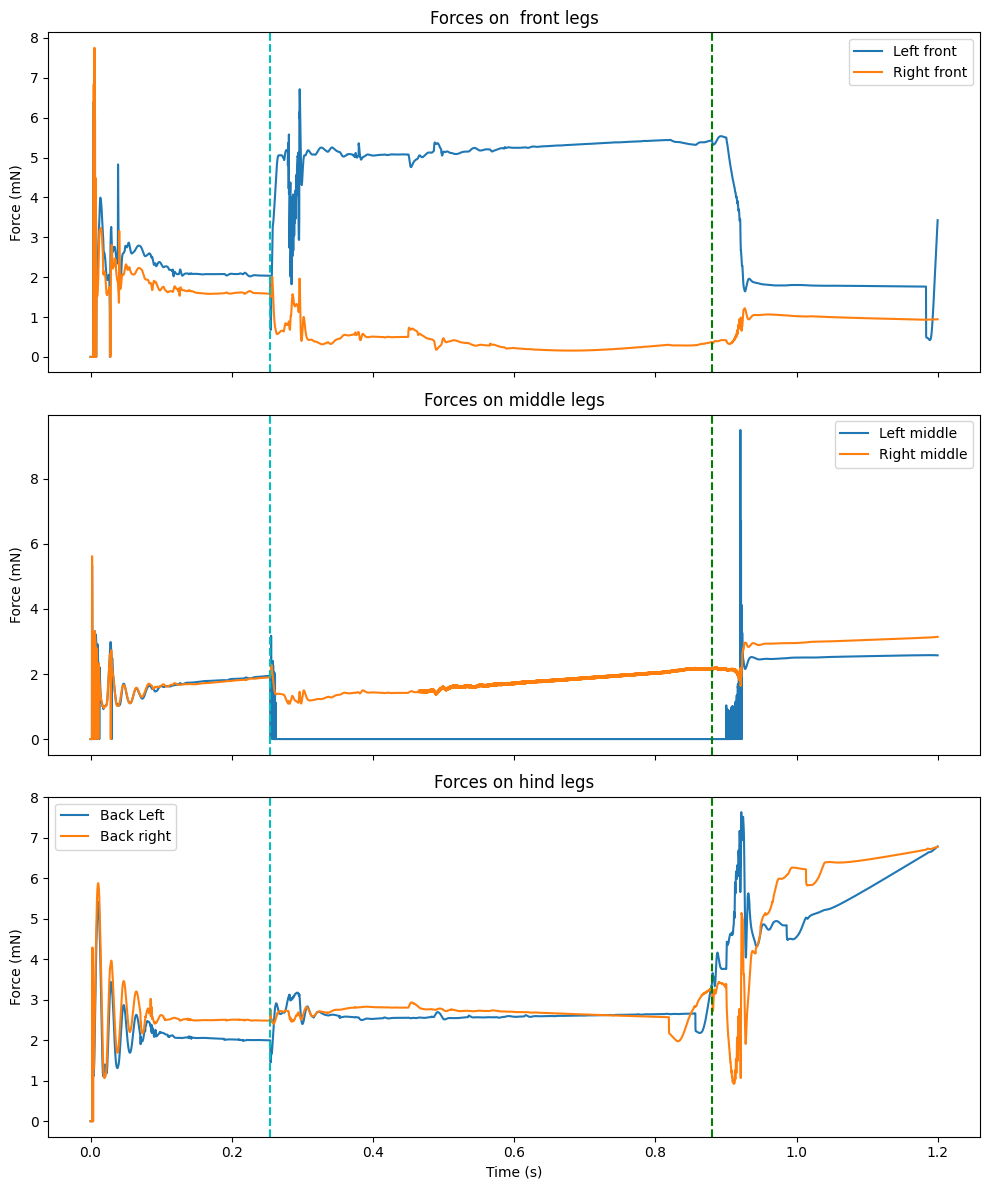

In [10]:
time_points = np.arange(0, run_time, timestep)

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
#  Plot for the first pair (4, 19)
axs[0].plot(time_points[0:12000], total_force_4[0:12000], label='Left front')
axs[0].plot(time_points[0:12000], total_force_19[0:12000], label='Right front')
axs[0].axvline(x=start_id * timestep, color='c', linestyle='--')
axs[0].axvline(x=end_id * timestep, color='g', linestyle='--')
axs[0].set_ylabel('Force (mN)')
axs[0].set_title('Forces on  front legs')
axs[0].legend()

# Plot for the second pair (9, 24)
axs[1].plot(time_points[0:12000], total_force_9[0:12000], label='Left middle')
axs[1].plot(time_points[0:12000], total_force_24[0:12000], label='Right middle')
axs[1].axvline(x=start_id * timestep, color='c', linestyle='--')
axs[1].axvline(x=end_id * timestep, color='g', linestyle='--')
axs[1].set_ylabel('Force (mN)')
axs[1].set_title('Forces on middle legs')
axs[1].legend()

# Plot for the third pair (14, 29)
axs[2].plot(time_points[0:12000], total_force_14[0:12000], label='Back Left')
axs[2].plot(time_points[0:12000], total_force_29[0:12000], label='Back right')
axs[2].axvline(x=start_id * timestep, color='c', linestyle='--')
axs[2].axvline(x=end_id * timestep, color='g', linestyle='--')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Force (mN)')
axs[2].set_title('Forces on hind legs')
axs[2].legend()


# Show the plot
plt.tight_layout()

file_path = os.path.join(folder_path, 'Force_legs.png')
plt.savefig(file_path)

plt.show()

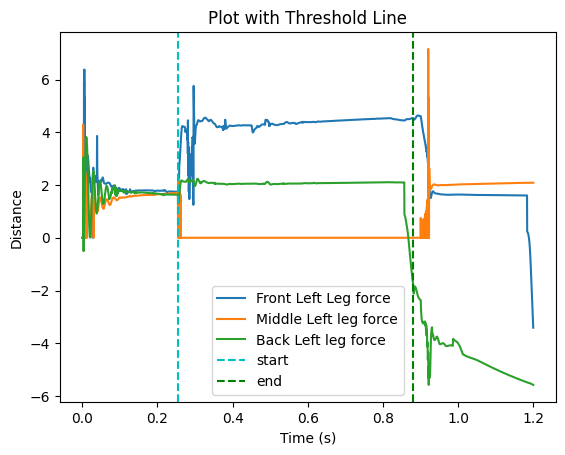

In [11]:
time_points = np.arange(0, run_time, timestep)
#plt.plot(time_points,theta_pred_sma_hist )
joint_forces = np.array(joint_forces)
plt.plot(time_points[0:12000], joint_forces[0:12000, 4, 2], label='Front Left Leg force')
plt.plot(time_points[0:12000], joint_forces[0:12000, 9, 2], label='Middle Left leg force')
plt.plot(time_points[0:12000], joint_forces[0:12000, 14, 2], label='Back Left leg force')
# Add a threshold line
# threshold = 8
# plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axvline(x=start_id*timestep, color='c', linestyle='--', label='start')
plt.axvline(x=end_id*timestep, color='g', linestyle='--', label='end')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Distance')
plt.title('Plot with Threshold Line')
plt.legend()

# Save the plot in the folder


# Show the plot
plt.show()

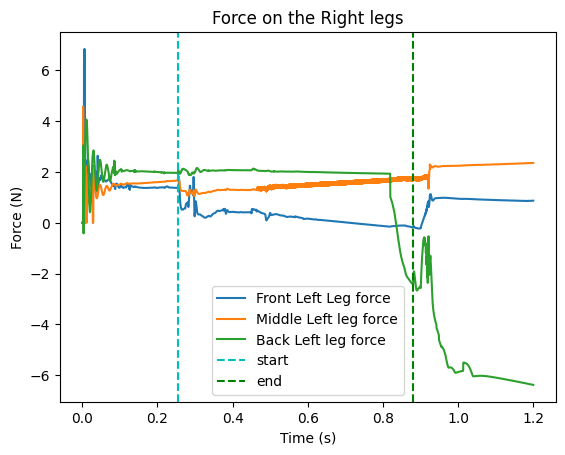

In [12]:
time_points = np.arange(0, run_time, timestep)

joint_forces = np.array(joint_forces)
plt.plot(time_points[0:12000], joint_forces[0:12000, 19, 2], label='Front Left Leg force')
plt.plot(time_points[0:12000], joint_forces[0:12000, 24, 2], label='Middle Left leg force')
plt.plot(time_points[0:12000], joint_forces[0:12000, 29, 2], label='Back Left leg force')

# Add a threshold line
# threshold = 8
# plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axvline(x=start_id*timestep, color='c', linestyle='--', label='start')
plt.axvline(x=end_id*timestep, color='g', linestyle='--', label='end')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Force on the Right legs')
plt.legend()

# Save the plot in the folder
file_path = os.path.join(folder_path, 'Right_force.png')
plt.savefig(file_path)

# Show the plot
plt.show()

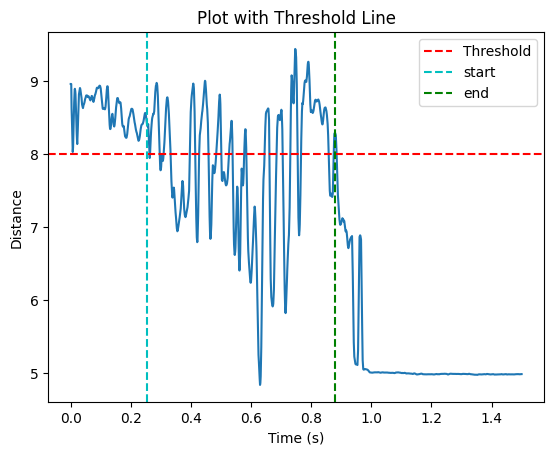

In [13]:
time_points = np.arange(0, run_time, timestep)
#plt.plot(time_points,theta_pred_sma_hist )
plt.plot(time_points,distances_sma_hist )
# Add a threshold line
threshold = 8
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axvline(x=start_id*timestep, color='c', linestyle='--', label='start')
plt.axvline(x=end_id*timestep, color='g', linestyle='--', label='end')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Distance')
plt.title('Plot with Threshold Line')
plt.legend()

# Save the plot in the folder
file_path = os.path.join(folder_path, 'distance_pred.png')
plt.savefig(file_path)

# Show the plot
plt.show()

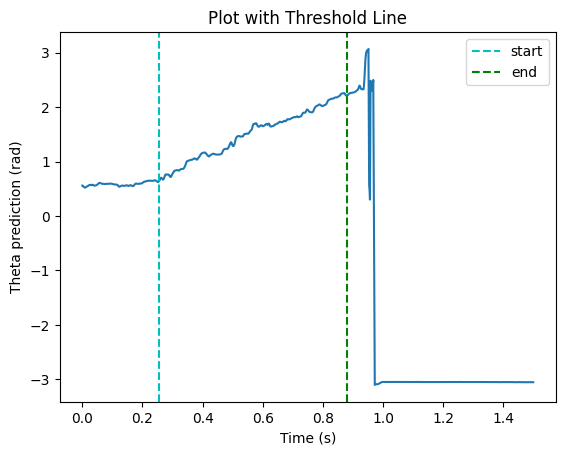

In [14]:
time_points = np.arange(0, run_time, timestep)
plt.plot(time_points,theta_pred_sma_hist )
# plt.plot(time_points,distances_sma_hist )
# Add a threshold line
# threshold = 8
# plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axvline(x=start_id*timestep, color='c', linestyle='--', label='start')
plt.axvline(x=end_id*timestep, color='g', linestyle='--', label='end')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Theta prediction (rad)')
plt.title('Plot with Threshold Line')
plt.legend()

# Save the plot in the folder
file_path = os.path.join(folder_path, 'theta.png')
plt.savefig(file_path)

# Show the plot
plt.show()

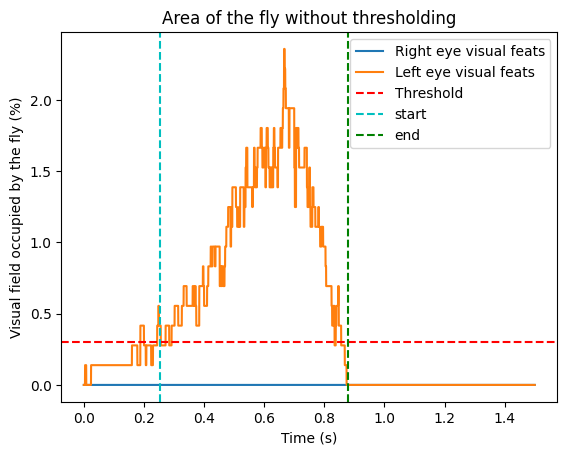

In [15]:
time_points = np.arange(0, run_time, timestep)
#plt.plot(time_points,distances_sma_hist )

# Multiply the values by 100
R_vis_feats_100 = [value * 100 for value in R_vis_feats]
L_vis_feats_100 = [value * 100 for value in L_vis_feats]


plt.plot(time_points, R_vis_feats_100, label='Right eye visual feats')
plt.plot(time_points, L_vis_feats_100, label='Left eye visual feats')

threshold = 0.3
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axvline(x=start_id*timestep, color='c', linestyle='--', label='start')
plt.axvline(x=end_id*timestep, color='g', linestyle='--', label='end')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Visual field occupied by the fly (%)')
plt.title('Area of the fly without thresholding')
plt.legend()

# Save the plot in the folder
file_path = os.path.join(folder_path, 'area_wo_filtered.png')
plt.savefig(file_path)

# Show the plot
plt.show()

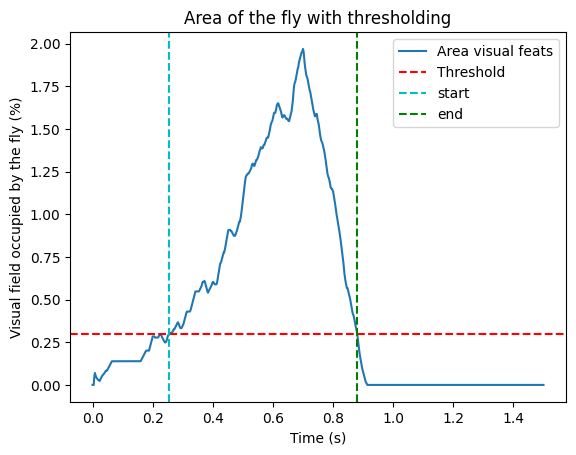

In [16]:
time_points = np.arange(0, run_time, timestep)
#plt.plot(time_points,distances_sma_hist )

area_vis_history_100 = [value * 100 for value in area_vis_history]
plt.plot(time_points, area_vis_history_100, label='Area visual feats')

threshold = 0.3
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axvline(x=start_id*timestep, color='c', linestyle='--', label='start')
plt.axvline(x=end_id*timestep, color='g', linestyle='--', label='end')

plt.xlabel('Time (s)')
plt.ylabel('Visual field occupied by the fly (%)')
plt.title('Area of the fly with thresholding')
plt.legend()

# Save the plot in the folder
file_path = os.path.join(folder_path, 'area_filtered.png')
plt.savefig(file_path)

# Show the plot
plt.show()

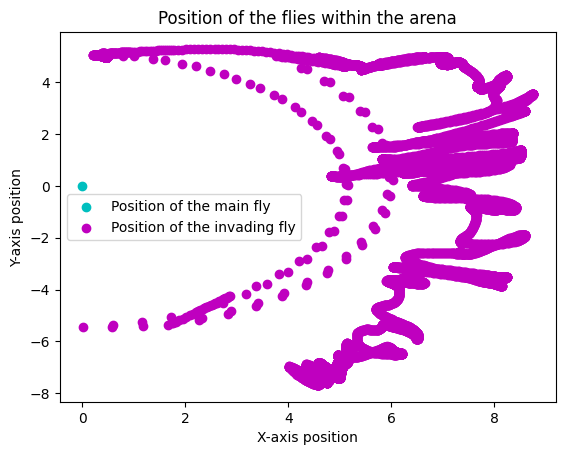

In [17]:
# Function to calculate x and y coordinates given angle and distance
def calculate_trajectory(angle, distance):
    x = distance * np.cos(angle)  # Calculate x coordinate
    y = distance * np.sin(angle)  # Calculate y coordinate
    return x, y

x_traj=[]
y_traj=[]
# Calculate trajectory for each combination of angle and distance
for i in range(len(theta_pred_sma_hist)):
    # Calculate trajectory
    x_traj.append(calculate_trajectory(real_angle_hist[i], distances_sma_hist[i])[0])
    y_traj.append(calculate_trajectory(real_angle_hist[i], distances_sma_hist[i])[1])

    
# Show the plot
plt.scatter(0,0,color='c', label='Position of the main fly')
plt.scatter(x_traj, y_traj, color='m', label='Position of the invading fly')
plt.title('Position of the flies within the arena')
plt.xlabel('X-axis position')
plt.ylabel('Y-axis position')
plt.legend()

file_path = os.path.join(folder_path, 'Position of the flies within the arena.png')
plt.savefig(file_path)

# plt.savefig('./example/recomputepassLeftPassv2.png')


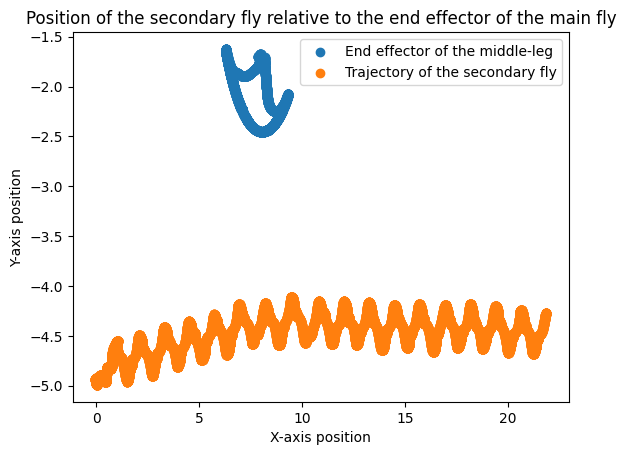

In [18]:
# Extract the first two columns from each array
x_end_eff = [arr[0][0] for arr in fly0.mid_leg_end_effector]
y_end_eff = [arr[0][1] for arr in fly0.mid_leg_end_effector]
z_end_eff = [arr[0][2] for arr in fly0.mid_leg_end_effector]


x_pos = [arr[0][0] for arr in fly_pos_hist]
y_pos = [arr[0][1] for arr in fly_pos_hist]

# Plot the data
plt.scatter(x_end_eff, y_end_eff,  label='End effector of the middle-leg')
plt.scatter(x_pos, y_pos, marker='o', label='Trajectory of the secondary fly')
plt.title('Position of the secondary fly relative to the end effector of the main fly')
plt.xlabel('X-axis position')
plt.ylabel('Y-axis position')
plt.legend()


file_path = os.path.join(folder_path, 'Position of the secondary fly relative to the end effector of the main fly.png')
plt.savefig(file_path)


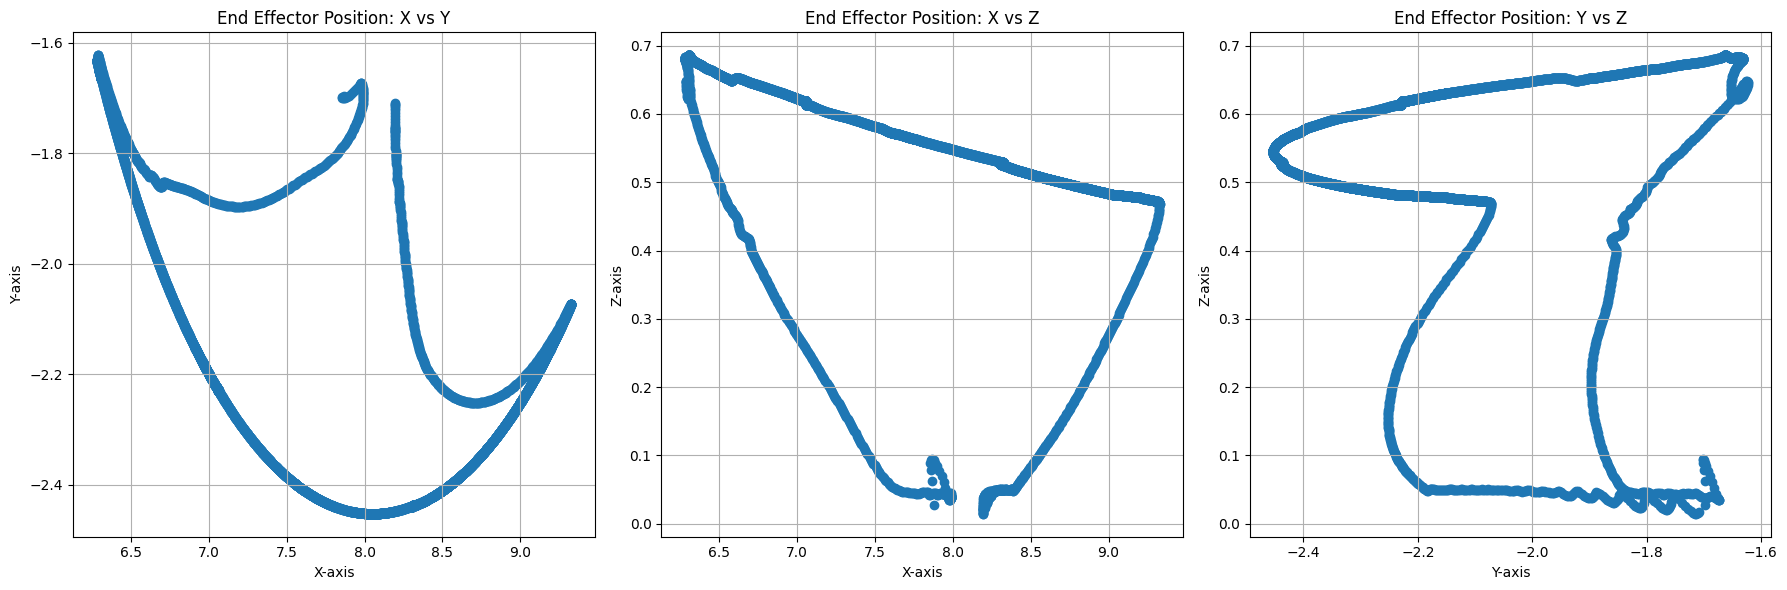

<Figure size 640x480 with 0 Axes>

In [19]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: X vs Y
axs[0].scatter(x_end_eff, y_end_eff, marker='o')
axs[0].set_xlabel('X-axis')
axs[0].set_ylabel('Y-axis')
axs[0].set_title('End Effector Position: X vs Y')
axs[0].grid(True)

# Second subplot: X vs Z
axs[1].scatter(x_end_eff, z_end_eff, marker='o')
axs[1].set_xlabel('X-axis')
axs[1].set_ylabel('Z-axis')
axs[1].set_title('End Effector Position: X vs Z')
axs[1].grid(True)

# Third subplot: Y vs Z
axs[2].scatter(y_end_eff, z_end_eff, marker='o')
axs[2].set_xlabel('Y-axis')
axs[2].set_ylabel('Z-axis')
axs[2].set_title('End Effector Position: Y vs Z')
axs[2].grid(True)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Save the figure
file_path = f'{folder_path}End_effector_position.png'  # Example file path, replace with your actual path
plt.savefig(file_path)

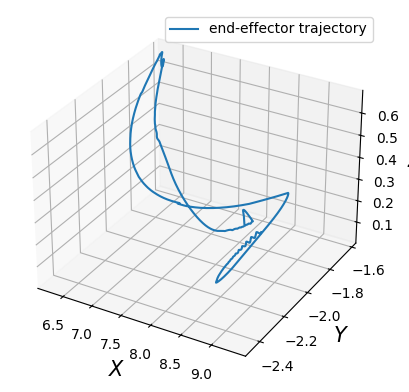

In [20]:
ax = plt.axes(projection='3d')

#ax.plot3D(x_end_eff, y_end_eff, z_end_eff)

ax.plot(x_end_eff, y_end_eff, z_end_eff, label='end-effector trajectory')
ax.legend()

ax.set_xlabel('$X$', fontsize=15)
ax.set_ylabel('$Y$', fontsize=15)
#ax.yaxis._axinfo['label']['space_factor'] = 3.0

# disable auto rotation
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('$Z$', fontsize=15, rotation = 0)

file_path = f'{folder_path}/End_effector_position_3D.png'  # Example file path, replace with your actual path
plt.savefig(file_path)

plt.show()

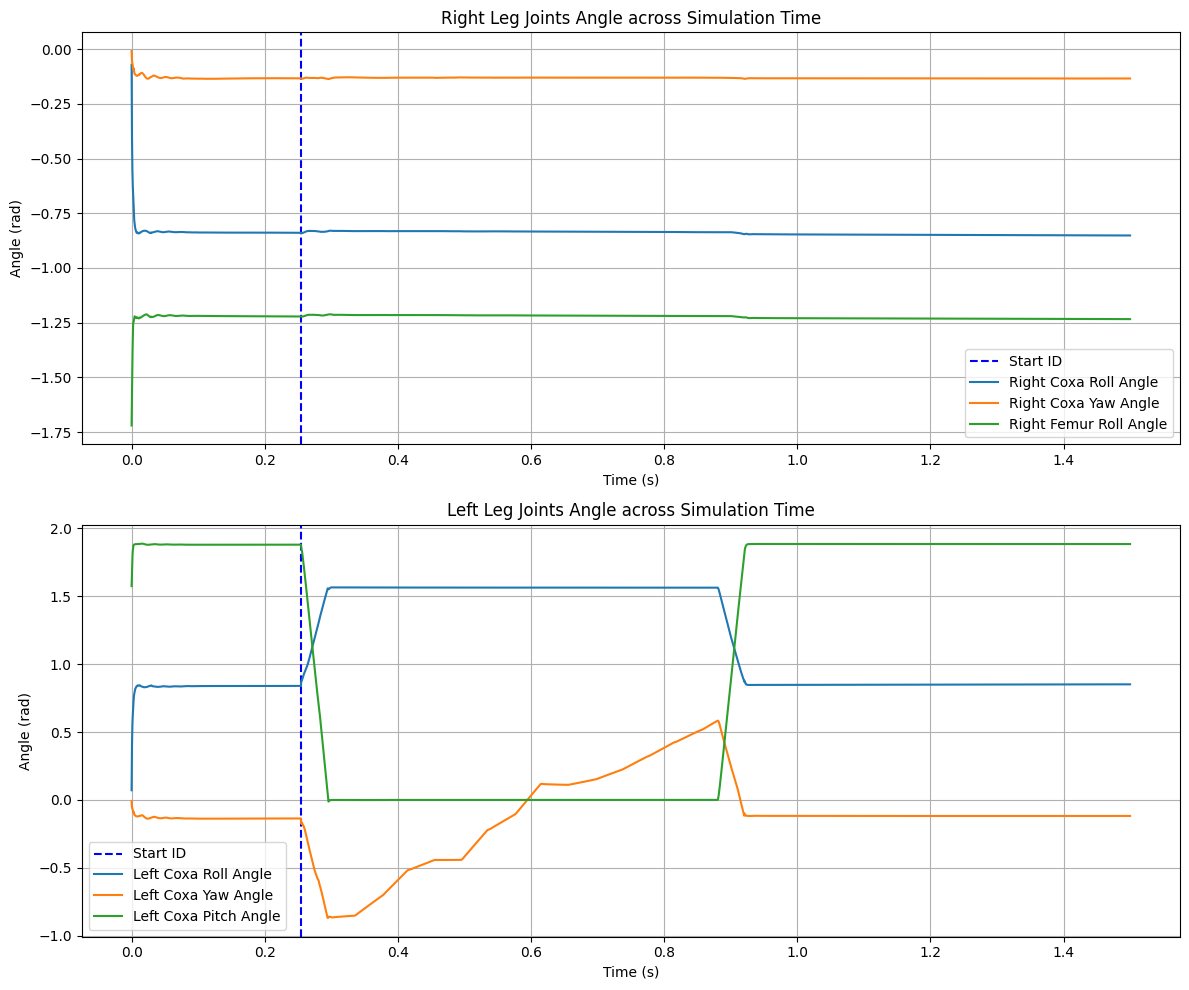

In [21]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# First subplot for Right Coxa and Femur angles
axs[0].axvline(x=(start_id * timestep), color='b', linestyle='--', label='Start ID')
axs[0].plot(time_points, fly_joints_angles_30, label='Right Coxa Roll Angle')
axs[0].plot(time_points, fly_joints_angles_28, label='Right Coxa Yaw Angle')
axs[0].plot(time_points, fly_joints_angles_31, label='Right Femur Roll Angle')
axs[0].set_title('Right Leg Joints Angle across Simulation Time')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Angle (rad)')
axs[0].legend()
axs[0].grid(True)

# Second subplot for Left Coxa angles
axs[1].axvline(x=(start_id * timestep), color='b', linestyle='--', label='Start ID')
axs[1].plot(time_points, fly_joints_angles_9, label='Left Coxa Roll Angle')
axs[1].plot(time_points, fly_joints_angles_7, label='Left Coxa Yaw Angle')
axs[1].plot(time_points, fly_joints_angles_8, label='Left Coxa Pitch Angle')
axs[1].set_title('Left Leg Joints Angle across Simulation Time')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Angle (rad)')
axs[1].legend()
axs[1].grid(True)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Save the figure
file_path = f'{folder_path}/Joint_Angles_Across_Simulation_Time.png'  # Example file path, replace with your actual path
plt.savefig(file_path)

# Show the plot
plt.show()

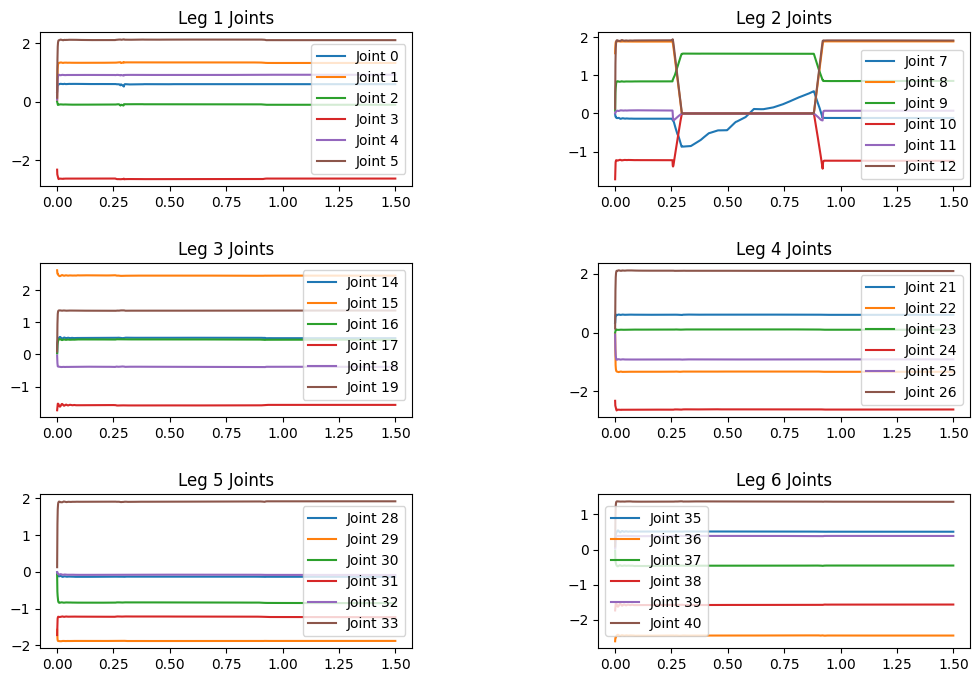

In [22]:
# Create a figure with subplots for each leg
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# Plot leg 1 joints
for i in range(len(leg1_joint_ids)):
    axs[0, 0].plot(time_points, [joint[i] for joint in leg1_joints], label=f'Joint {leg1_joint_ids[i]}')
axs[0, 0].set_title('Leg 1 Joints')
axs[0, 0].legend()

# Plot leg 2 joints
for i in range(len(leg2_joint_ids)):
    axs[0, 1].plot(time_points, [joint[i] for joint in leg2_joints], label=f'Joint {leg2_joint_ids[i]}')
axs[0, 1].set_title('Leg 2 Joints')
axs[0, 1].legend()

# Plot leg 3 joints
for i in range(len(leg3_joint_ids)):
    axs[1, 0].plot(time_points, [joint[i] for joint in leg3_joints], label=f'Joint {leg3_joint_ids[i]}')
axs[1, 0].set_title('Leg 3 Joints')
axs[1, 0].legend()

# Plot leg 4 joints
for i in range(len(leg4_joint_ids)):
    axs[1, 1].plot(time_points, [joint[i] for joint in leg4_joints], label=f'Joint {leg4_joint_ids[i]}')
axs[1, 1].set_title('Leg 4 Joints')
axs[1, 1].legend()

# Plot leg 5 joints
for i in range(len(leg5_joint_ids)):
    axs[2, 0].plot(time_points, [joint[i] for joint in leg5_joints], label=f'Joint {leg5_joint_ids[i]}')
axs[2, 0].set_title('Leg 5 Joints')
axs[2, 0].legend()

# Plot leg 6 joints
for i in range(len(leg6_joint_ids)):
    axs[2, 1].plot(time_points, [joint[i] for joint in leg6_joints], label=f'Joint {leg6_joint_ids[i]}')
axs[2, 1].set_title('Leg 6 Joints')
axs[2, 1].legend()

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

file_path = f'{folder_path}/Joint_Angles_Across_Simulation_Time_all.png'  # Example file path, replace with your actual path
plt.savefig(file_path)

# Show the plot
plt.show()